In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re

In [2]:
reviews = pd.read_csv("../data/raw/all_reviews.csv", low_memory=False)

In [3]:
reviews.shape

(9901889, 19)

In [4]:
reviews.head()

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job,index
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,NaN,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design,NaN
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",NaN,v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee,NaN
2,4.0,"Supervising the manufacturing the processes, e...","Current Employee, more than 1 year",This company is a best opportunity for me to l...,"Monthly Target work,Maintain production schedu...",NaN,v,o,v,2,3,2,2,2.0,2.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Aug 12, 2021",Production Engineer,NaN
3,1.0,terrible,"Current Employee, more than 1 year",I wish there were some to list,too many to list here,NaN,x,x,x,1.0,3.0,1.0,3.0,1.0,NaN,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Sep 24, 2020",Senior Account Executive,NaN
4,4.0,"It could be so good, but it isn’t","Current Employee, more than 3 years",Fast Paced. Endless challenges. Inclusive envi...,The biggest perk of the job provides no value ...,NaN,o,o,o,3.0,3.0,3.0,1.0,4.0,5.0,https://www.glassdoor.com/Reviews/Calgary-Flam...,"Mar 25, 2023",Assistant Manager,NaN


In [15]:
import pandas as pd
import re

# Function to clean numerical rating columns
def clean_rating_columns(df, columns):
    """
    Clean numerical rating columns by converting them to float and removing invalid entries.
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[col])
        df[col] = df[col].astype(float)
    return df

# Function to handle missing values
def handle_missing_values(df, columns_to_fill, fill_value=0.0):
    """
    Fill missing values for specified columns with a given value.
    """
    for col in columns_to_fill:
        df[col] = df[col].fillna(fill_value).astype(float)
    return df

# Function to extract year from date
def extract_year(df, date_column, year_column):
    """
    Extract the year from a date column and create a new year column.
    """
    df[year_column] = df[date_column].str.split().str[2].astype(int)
    return df[df[year_column] > 2014]

# Function to extract firm names from the firm_link
def extract_firm_names(df, firm_link_column, firm_name_column):
    """
    Extract firm names from firm_link and filter firms with frequent mentions.
    """
    def extract_name(firm_link):
        match = re.search(r'(?<=/)([A-Za-z0-9\-]+)(?=-Reviews)', firm_link)
        return match.group(1) if match else None

    df[firm_name_column] = df[firm_link_column].apply(extract_name)
    firm_counts = df[firm_name_column].value_counts()
    valid_firms = firm_counts[firm_counts >= 100].index
    return df[df[firm_name_column].isin(valid_firms)]

# Function to unify employment statuses
def unify_employment_statuses(df, status_column):
    """
    Standardize employment statuses.
    """
    def unify_status(status):
        if "Current" in status:
            if "Contractor" in status:
                return "Current Contractor"
            elif "Freelancer" in status:
                return "Current Freelancer"
            elif "Intern" in status:
                return "Current Intern"
            elif "Self-employed" in status:
                return "Current Self-employed"
            else:
                return "Current Employee"
        elif "Former" in status:
            if "Contractor" in status:
                return "Former Contractor"
            elif "Freelancer" in status:
                return "Former Freelancer"
            elif "Intern" in status:
                return "Former Intern"
            elif "PhD" in status:
                return "Former PhD"
            elif "Self-employed" in status:
                return "Former Self-employed"
            else:
                return "Former Employee"
        else:
            return "Other"

    df[status_column] = df[status_column].apply(unify_status)
    return df

# Main cleaning function
def clean_dataset(file_path, rating_columns, missing_columns, firm_link_column, status_column, date_column, year_column):
    """
    Clean the dataset by applying all cleaning functions step by step.
    """
    # Read the data
    df = pd.read_csv(file_path, low_memory=False)
    
    # Clean rating columns
    df = clean_rating_columns(df, rating_columns)
    
    # Drop unnecessary columns
    df.drop(columns=["title", "advice", "index", "Business Outlook"], inplace=True)
    
    # Drop rows with significant missing values
    df.dropna(subset=['pros', 'cons', 'Culture & Values'], inplace=True)
    
    # Extract year and filter rows
    df = extract_year(df, date_column, year_column)
    
    # Handle missing values in specific columns
    df = handle_missing_values(df, missing_columns, fill_value=0.0)
    
    # Extract and filter firm names
    df = extract_firm_names(df, firm_link_column, 'firm_name')
    
    # Unify employment statuses
    df = unify_employment_statuses(df, status_column)
    
    return df

# Usage
file_path = "../data/raw/all_reviews.csv"
rating_columns = ['Work/Life Balance', 'Compensation and Benefits', 'Senior Management', 'Career Opportunities']
missing_columns = ['Diversity & Inclusion']
firm_link_column = 'firm_link'
status_column = 'status'
date_column = 'date'
year_column = 'year'
job_column = 'job'

cleaned_reviews = clean_dataset(
    file_path=file_path,
    rating_columns=rating_columns,
    missing_columns=missing_columns,
    firm_link_column=firm_link_column,
    status_column=status_column,
    date_column=date_column,
    year_column=year_column,
    job_column=job_column
)

# Check missing values in the cleaned dataset
print(cleaned_reviews.isna().sum())


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_22228/644112078.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_22228/644112078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


rating                             0
status                             0
pros                               0
cons                               0
advice                       6016206
Recommend                          0
CEO Approval                       0
Business Outlook                   0
Career Opportunities               0
Compensation and Benefits          0
Senior Management                  0
Work/Life Balance                  0
Culture & Values                   0
Diversity & Inclusion              0
firm_link                          0
date                               0
job                                0
index                        5892160
year                               0
firm_name                          0
dtype: int64


In [21]:
print(cleaned_reviews.shape)
print(cleaned_reviews.isna().sum())

(6016214, 18)
rating                       0
status                       0
pros                         0
cons                         0
Recommend                    0
CEO Approval                 0
Business Outlook             0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
Diversity & Inclusion        0
firm_link                    0
date                         0
job                          0
year                         0
firm_name                    0
dtype: int64


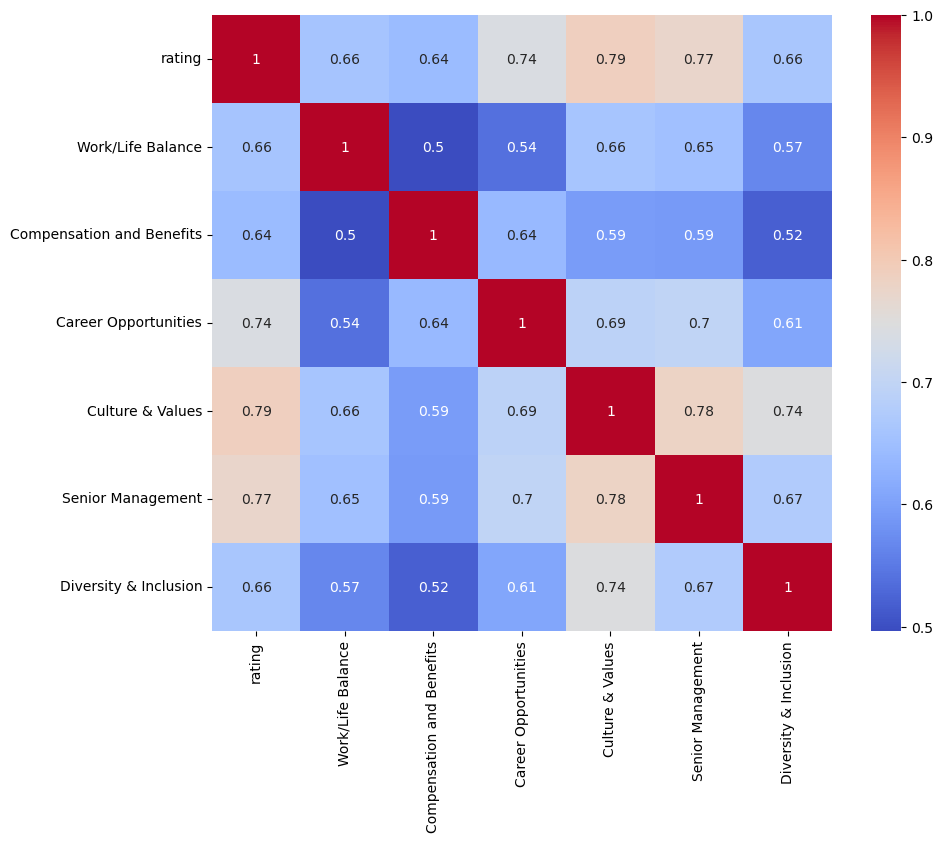

In [27]:
# Select relevant numerical columns
numerical_cols = ['rating', 'Work/Life Balance', 'Compensation and Benefits', 'Career Opportunities', 'Culture & Values', 'Senior Management','Diversity & Inclusion']
corr_matrix = cleaned_reviews[numerical_cols].corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

- Work/Life Balance (0.66): Directly related to employee satisfaction and frequently highlighted as a key workplace factor.
- Culture & Values (0.79): Strongest correlation with rating, making it essential for analysis.
- Senior Management (0.77): Indicates a significant impact on employee perception.
- Career Opportunities (0.74): Highly correlated with rating, crucial for assessing growth potential and satisfaction.
- Diversity & Inclusion (0.66): While correlated, it’s slightly less impactful compared to the others. However, we might address how inclusivity initiatives affect workplace well-being and satisfaction

In [41]:
"""
Check how the values look like and what we need to clean

"""

#for col in cleaned_reviews:
#    print(f"Value counts for column {col}:")
#    print(cleaned_reviews[col].value_counts())
#    print("\n")

Value counts for column rating:
rating
5.0    1074956
4.0     960909
3.0     688419
2.0     291067
1.0     279328
Name: count, dtype: int64


Value counts for column status:
status
Current Employee                                               635516
Current Employee, more than 1 year                             402304
Former Employee                                                325517
Former Employee, more than 1 year                              319383
Current Employee, more than 3 years                            301719
                                                                ...  
Former Intern, more than 10 years                                   1
Former Intern, more than 5 years                                    1
KEY NOT FOUND: jobLine.reserve-former, more than 8 years            1
KEY NOT FOUND: jobLine.seasonal-current, more than 10 years         1
KEY NOT FOUND: jobLine.seasonal-current, more than 5 years          1
Name: count, Length: 85, dtype: int64


Value cou

In [77]:
clean_reviews.drop(columns = ["advice", "index", "date", "Business Outlook"], inplace = True)

In [79]:
clean_reviews.shape

(7630183, 16)

In [81]:
clean_reviews.isna().sum()

rating                             0
title                          22334
status                             0
pros                              16
cons                              44
Recommend                          0
CEO Approval                       0
Career Opportunities               0
Compensation and Benefits          0
Senior Management                  0
Work/Life Balance                  0
Culture & Values              119633
Diversity & Inclusion        4327036
firm_link                          0
job                                0
year                               0
dtype: int64

In [83]:
clean_reviews["Diversity & Inclusion"].value_counts()

Diversity & Inclusion
5.0    1369391
4.0     846871
3.0     566861
1.0     283727
2.0     236297
Name: count, dtype: int64

In [85]:
clean_reviews['Diversity & Inclusion'][~clean_reviews['Diversity & Inclusion'].apply(pd.to_numeric, errors='coerce').notnull()]

3         NaN
29        NaN
31        NaN
32        NaN
33        NaN
           ..
9901884   NaN
9901885   NaN
9901886   NaN
9901887   NaN
9901888   NaN
Name: Diversity & Inclusion, Length: 4327036, dtype: float64

In [89]:
clean_reviews = clean_reviews.dropna(subset=['pros', 'cons', "Culture & Values"])

In [91]:
clean_reviews.isna().sum()

rating                             0
status                             0
pros                               0
cons                               0
Recommend                          0
CEO Approval                       0
Career Opportunities               0
Compensation and Benefits          0
Senior Management                  0
Work/Life Balance                  0
Culture & Values                   0
Diversity & Inclusion        4215811
firm_link                          0
job                                0
year                               0
dtype: int64

In [93]:
clean_reviews.shape

(7510490, 15)

In [95]:
missing_percentage = clean_reviews['Diversity & Inclusion'].isna().sum() / len(df) * 100
print(f"Missing Percentage: {missing_percentage:.2f}%")

Missing Percentage: 42.58%


In [101]:
clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].fillna("0.0")

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_7302/1289633316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].fillna("0.0")


In [111]:
# Replace "No response" with NaN first
clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].replace("No response", np.nan)

# Replace NaN with 0.0
clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].fillna(0.0)

# Ensure the column is numeric
clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].astype(float)

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_7302/3110252707.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].replace("No response", np.nan)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_7302/3110252707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_reviews['Diversity & Inclusion'] = clean_reviews['Diversity & Inclusion'].replace("No response", np.nan)
/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T

In [113]:
clean_reviews.isna().sum()

rating                       0
status                       0
pros                         0
cons                         0
Recommend                    0
CEO Approval                 0
Career Opportunities         0
Compensation and Benefits    0
Senior Management            0
Work/Life Balance            0
Culture & Values             0
Diversity & Inclusion        0
firm_link                    0
job                          0
year                         0
dtype: int64

In [115]:
clean_reviews.shape

(7510490, 15)

In [119]:
clean_reviews['year'] = clean_reviews['year'].astype(int)
clean_reviews = clean_reviews[clean_reviews['year'] > 2014]

/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_7302/4289779218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_reviews['year'] = clean_reviews['year'].astype(int)


In [121]:
clean_reviews.shape

(6807037, 15)

In [125]:
clean_reviews['status'].unique()

array(['Current Employee, more than 10 years',
       'Former Employee, less than 1 year',
       'Current Employee, more than 1 year',
       'Current Employee, more than 3 years',
       'Former Employee, more than 5 years',
       'Former Employee, more than 1 year', 'Current Employee',
       'Former Employee, more than 8 years',
       'Former Employee, more than 3 years',
       'Current Employee, more than 5 years', 'Former Employee',
       'Current Employee, less than 1 year', 'Former Contractor',
       'Former Employee, more than 10 years',
       'Current Employee, more than 8 years', 'Former Temporary Employee',
       'Current Contractor', 'Former Intern, less than 1 year',
       'Current Contractor, more than 1 year',
       'Current Contractor, more than 5 years',
       'Current Freelancer, less than 1 year', 'Former Intern',
       'Current Intern, less than 1 year',
       'Former Contractor, more than 10 years',
       'Former Freelancer, less than 1 year', 'Curren

In [127]:
# Filter out rows where 'status' contains "KEY NOT FOUND:"
clean_reviews = clean_reviews[~clean_reviews['status'].str.contains("KEY NOT FOUND:", na=False)] #~ negates the filter condition, meaning it keeps rows that do not contain "KEY NOT FOUND:".

In [131]:
unique_status = clean_reviews['status'].unique()
print(f"Unique statuses after cleaning: {len(unique_status)}")

Unique statuses after cleaning: 72


In [135]:
clean_reviews['status'] = reviews['status']

In [137]:
clean_reviews['status'].unique()

array(['Current Employee, more than 10 years',
       'Former Employee, less than 1 year',
       'Current Employee, more than 1 year',
       'Current Employee, more than 3 years',
       'Former Employee, more than 5 years',
       'Former Employee, more than 1 year', 'Current Employee',
       'Former Employee, more than 8 years',
       'Former Employee, more than 3 years',
       'Current Employee, more than 5 years', 'Former Employee',
       'Current Employee, less than 1 year', 'Former Contractor',
       'Former Employee, more than 10 years',
       'Current Employee, more than 8 years', 'Former Temporary Employee',
       'Current Contractor', 'Former Intern, less than 1 year',
       'Current Contractor, more than 1 year',
       'Current Contractor, more than 5 years',
       'Current Freelancer, less than 1 year', 'Former Intern',
       'Current Intern, less than 1 year',
       'Former Contractor, more than 10 years',
       'Former Freelancer, less than 1 year', 'Curren

In [332]:
clean_reviews["job"] = reviews["job"]
clean_reviews["job"].value_counts()

job
Anonymous Employee    995916
                      287913
Software Engineer      93970
Manager                79607
Sales Associate        77447
                       ...  
Supply Chain              10
Sales Colleague           10
Beauty Advisor            10
Statistician              10
Product Marketing         10
Name: count, Length: 4412, dtype: int64

In [334]:
def clean_job_titles(df, job_column):
    """
    Clean and standardize job titles in a DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the job titles to clean.
    - job_column (str): Name of the column with job titles.
    
    Returns:
    - pd.DataFrame: Cleaned DataFrame with standardized job titles.
    """
    # Replace empty strings or NaN values with "Anonymous Employee"
    df[job_column].replace(' ', 'Anonymous Employee', inplace=True)
    df[job_column].fillna('Anonymous Employee', inplace=True)
    
    # Strip leading/trailing spaces
    df[job_column] = df[job_column].str.strip()
    
    # Count occurrences of each job title
    job_counts = df[job_column].value_counts()
    
    # Filter out jobs mentioned less than 100 times
    valid_jobs = job_counts[job_counts >= 100].index
    df = df[df[job_column].isin(valid_jobs)]
    
    # Replace specific job titles
    job_replacements = {
        'Salees Associate': 'Sales Associate',
        'IT Strategy Consultant': 'IT Consultant',
        'Sales Associate/Cashier': 'Cashier',
        'Senior Software Engineer': 'Software Engineer', 
        'Senior Systems Engineer': 'Software Engineer', 
        'Senior Software Developer': 'Software Engineer', 
        'Associate Software Engineer': 'Software Engineer',
        'Sales': 'Sales Associate', 
        'Salees Associate ': 'Sales Associate', 
        'Retail Sales Associate': 'Sales Associate',
        'Sales Assistant': 'Sales Associate', 
        'Sales Representative': 'Sales Associate',
        'Systems Engineer': 'Software Engineer',
        'Senior Associate': 'Associate',
        'Senior Analyst ': 'Analyst',
        'Business Analyst': 'Analyst', 
        'Senior Business Analyst ': 'Analyst',
        'Senior Business Analyst': 'Analyst', 
        'IT Analyst': 'Analyst',
        'Senior Analyst': 'Analyst',
        'Programmer Analyst': 'Analyst', 
        'Financial Analyst': 'Analyst',
        'Server': 'Waiter/Waitress', 
        'Waiter': 'Waiter/Waitress', 
        'Waitress': 'Waiter/Waitress',
        'Warehouse Worker': 'Warehouse Associate',
        'Human Resources': 'HR', 
        'Recruiter': 'HR',
        'Customer Service Representative': 'Customer Service', 
        'Customer Service Representative (CSR)': 'Customer Service',
        'Customer Assistant': 'Customer Service', 
        'Customer Service Associate': 'Customer Service',
        'Executive Assistant': 'Administrative Assistant', 
        'Associate Director': 'Director',
        'Shift Supervisor': 'Supervisor',
        'Graduate Research Assistant': 'Researcher', 
        'Research Assistant': 'Researcher'
    }
    df[job_column] = df[job_column].replace(job_replacements)
    
    # Apply broader job title standardizations
    def standardize_jobs(job):
        if 'Teacher' in job:
            return 'Teacher'
        elif 'Manager' in job:
            return 'Manager'
        elif 'Consultant' in job:
            return 'Consultant'
        elif 'Intern' in job:
            return 'Intern'
        elif 'Team Member' in job or 'Crew Member' in job:
            return 'Team Member'
        return job
    
    df[job_column] = df[job_column].apply(standardize_jobs)
    
    return df


/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_7302/1516026913.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/7h/j883bpy50yx9ffn06wrdxzy00000gn/T/ipykernel_7302/1516026913.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

In [357]:
# Get the value counts for the 'job' column and sort them in descending order
job_counts = clean_reviews['job'].value_counts()

# Display the top 40 most frequent job titles
top_40_jobs = job_counts.head(40)
print(top_40_jobs)

job
Anonymous Employee            1283829
Manager                        590256
Software Engineer              200063
Sales Associate                146203
Consultant                     129203
Analyst                        117105
Customer Service                96658
Cashier                         68294
Associate                       62844
Team Member                     59789
Director                        38167
Software Developer              27601
Engineer                        26568
Supervisor                      25271
Intern                          22594
Administrative Assistant        20723
Barista                         20311
HR                              19230
Researcher                      18321
Team Leader                     18149
Warehouse Associate             17921
Account Executive               14598
Vice President                  14159
Registered Nurse                13637
Waiter/Waitress                 13474
Teacher                         13444
Senior E